# Downside Risk

In [1]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

from scipy.stats import norm
from risk_kit import Metrics, pre_processing_hfi
pd.options.display.float_format = '{:.6f}'.format

In [2]:
hfi = pre_processing_hfi()
hfi = hfi["2009":"2018"]
#print(hfi.head()
hfi.tail()

/home/solidsnake/trading/portfolio_construction/risk_kit.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  hfi = pd.read_csv("data/edhec-hedgefundindices.csv", header=0, index_col=0, parse_dates=True)


,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
2018-07,0.002100,-0.005800,0.009300,0.004000,-0.001000,0.005500,0.002200,-0.001400,0.006700,-0.002100,0.004500,-0.005200,0.001800
2018-08,0.002400,0.016600,0.000200,-0.027700,0.000400,0.001100,0.001700,-0.000700,0.003500,0.005000,-0.000200,-0.021400,0.001500
2018-09,0.003400,-0.005400,0.005000,-0.011000,-0.001600,0.003200,0.003600,0.000600,-0.002300,0.002800,0.001800,0.003600,-0.002200
2018-10,-0.007300,-0.031400,-0.015800,-0.031500,-0.012900,-0.025700,-0.002300,-0.009600,-0.040200,-0.008000,-0.010900,0.023700,-0.026900
2018-11,-0.006800,-0.005300,-0.019300,0.012000,-0.021100,-0.003400,-0.006700,-0.008700,-0.004400,0.011900,-0.006300,-0.002100,-0.007100


In [3]:
# semi deviation
hfi[hfi<0].std(ddof=0)

Convertible Arbitrage    0.006681
CTA Global               0.010996
Distressed Securities    0.009498
Emerging Markets         0.015276
Equity Market Neutral    0.005186
Event Driven             0.010135
Fixed Income Arbitrage   0.003321
Global Macro             0.005075
Long/Short Equity        0.012139
Merger Arbitrage         0.003611
Relative Value           0.005711
Short Selling            0.021240
Funds Of Funds           0.007948
dtype: float64

In [4]:
metrics = Metrics(starting_amount=1)

In [5]:
hfi.agg(metrics.semideviation_daily_ret).sort_values()

Fixed Income Arbitrage   0.003321
Merger Arbitrage         0.003611
Global Macro             0.005075
Equity Market Neutral    0.005186
Relative Value           0.005711
Convertible Arbitrage    0.006681
Funds Of Funds           0.007948
Distressed Securities    0.009498
Event Driven             0.010135
CTA Global               0.010996
Long/Short Equity        0.012139
Emerging Markets         0.015276
Short Selling            0.021240
dtype: float64

In [6]:
hfi.agg(metrics.semideviation).sort_values()

Fixed Income Arbitrage   0.006490
Equity Market Neutral    0.007202
Merger Arbitrage         0.007640
Relative Value           0.009502
Global Macro             0.009689
Convertible Arbitrage    0.010382
Funds Of Funds           0.012246
Event Driven             0.015833
Distressed Securities    0.016712
Long/Short Equity        0.018519
CTA Global               0.019215
Emerging Markets         0.023606
Short Selling            0.031207
dtype: float64

### Var and CVaR
- Historic VaR
- Gaussian Parametric VaR
- Modified Cornish-Fisher VaR

In [7]:
np.percentile(hfi, 5,axis=0)

array([-0.00966, -0.02812, -0.01936, -0.03273, -0.0077 , -0.02498,
       -0.00548, -0.01321, -0.02385, -0.00791, -0.01021, -0.0654 ,
       -0.01786])

In [8]:
def historical_var(data: pd.Series | pd.DataFrame, level=5):
    """
    computes VaR based on historical data over the data frequency.
    There is a 5% (level=5) you are going to lose the "calculated amount" in a certain period
    (given by the data frequency)
    """
    if isinstance(data, pd.DataFrame):
        return data.agg(historical_var, level=level)
    elif isinstance(data, pd.Series):
        return -np.percentile(data, level)
    else:
        raise TypeError("Expected input are to be Series or DataFrame")

In [9]:
historical_var(hfi)

Convertible Arbitrage    0.009660
CTA Global               0.028120
Distressed Securities    0.019360
Emerging Markets         0.032730
Equity Market Neutral    0.007700
Event Driven             0.024980
Fixed Income Arbitrage   0.005480
Global Macro             0.013210
Long/Short Equity        0.023850
Merger Arbitrage         0.007910
Relative Value           0.010210
Short Selling            0.065400
Funds Of Funds           0.017860
dtype: float64

In [10]:
historical_var = hfi.agg(metrics.historical_var)

In [11]:
# returns z-score
z_score = norm.ppf(.05)
z_score

-1.6448536269514729

In [12]:
-(hfi.mean() + z_score*hfi.std(ddof=0))

Convertible Arbitrage    0.015805
CTA Global               0.032004
Distressed Securities    0.019306
Emerging Markets         0.033385
Equity Market Neutral    0.007582
Event Driven             0.018503
Fixed Income Arbitrage   0.007050
Global Macro             0.014327
Long/Short Equity        0.022484
Merger Arbitrage         0.006878
Relative Value           0.010125
Short Selling            0.066540
Funds Of Funds           0.015116
dtype: float64

In [13]:
gaussian_var = hfi.agg(metrics.cornish_fisher_var, level = 5, modified=False)

In [14]:
modified_gaussian_var = hfi.agg(metrics.cornish_fisher_var, level=5, modified=True)

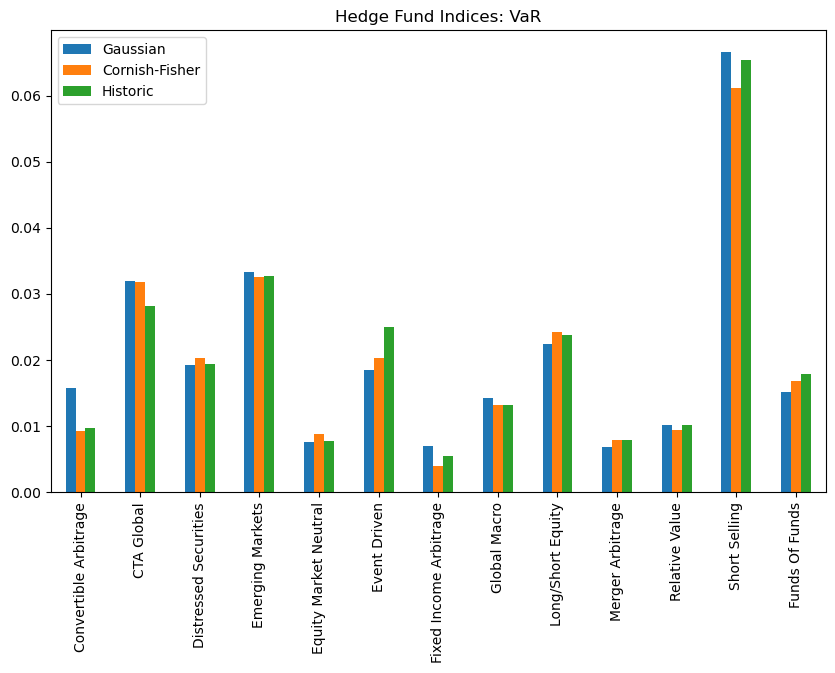

In [15]:
var_list  = [gaussian_var, modified_gaussian_var, historical_var]
comparison = pd.concat(var_list, axis=1)
comparison.columns = ["Gaussian", "Cornish-Fisher", "Historic"]
comparison.plot.bar(title = "Hedge Fund Indices: VaR");

### Conditional VaR
if that 5% happens (the worst 5% of all possibile cases). In that case CVaR represents the average loss conditioned on the worst case over a certain period of time

In [16]:
hfi.agg(metrics.historical_cvar)

Convertible Arbitrage    0.018433
CTA Global               0.036517
Distressed Securities    0.028033
Emerging Markets         0.048117
Equity Market Neutral    0.014350
Event Driven             0.030333
Fixed Income Arbitrage   0.008767
Global Macro             0.016967
Long/Short Equity        0.039233
Merger Arbitrage         0.010817
Relative Value           0.015533
Short Selling            0.078467
Funds Of Funds           0.025383
dtype: float64